<a href="https://colab.research.google.com/github/abhinavsagar/Breast-cancer-classification/blob/master/Breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading & Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet201
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetLarge,NASNetMobile
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [3]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

classe0_train=np.array(Dataset_loader('/content/drive/MyDrive/Clase0-Normal',224))
classe1_train=np.array(Dataset_loader('/content/drive/MyDrive/Clase1-DR',224))
classe2_train=np.array(Dataset_loader('/content/drive/MyDrive/Clase2-Otras',224))
classe3_train=np.array(Dataset_loader('/content/drive/MyDrive/Clase3-NoClassifiable',224))

classe0_test=np.array(Dataset_loader('/content/drive/MyDrive/Clase0-Normaltest',224))
classe1_test=np.array(Dataset_loader('/content/drive/MyDrive/Clase1-DRtest',224))
classe2_test=np.array(Dataset_loader('/content/drive/MyDrive/Clase2-Otrastest',224))
classe3_test=np.array(Dataset_loader('/content/drive/MyDrive/Clase3-NoClassifiabletest',224))



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


# Create Label

In [4]:
# Create labels
classe0_train_label=np.zeros(len(classe0_train))
classe1_train_label=np.ones(len(classe1_train))
classe2_train_label=np.zeros(len(classe2_train))+2
classe3_train_label=np.ones(len(classe3_train)) +2

classe0_test_label = np.zeros(len(classe0_test))
classe1_test_label = np.ones(len(classe1_test))
classe2_test_label = np.zeros(len(classe2_test))+2
classe3_test_label = np.ones(len(classe3_test)) +2


# Merge data 
X_train = np.concatenate((classe0_train, classe1_train , classe2_train , classe3_train), axis = 0)
Y_train = np.concatenate((classe0_train_label, classe1_train_label , classe2_train_label , classe3_train_label), axis = 0)
X_test = np.concatenate((classe0_test, classe1_test , classe2_test , classe3_test), axis = 0)
Y_test = np.concatenate((classe0_test_label, classe1_test_label ,classe2_test_label , classe3_test_label ), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 4)
Y_test = to_categorical(Y_test, num_classes= 4)

# Train and Evalutation split

In [5]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

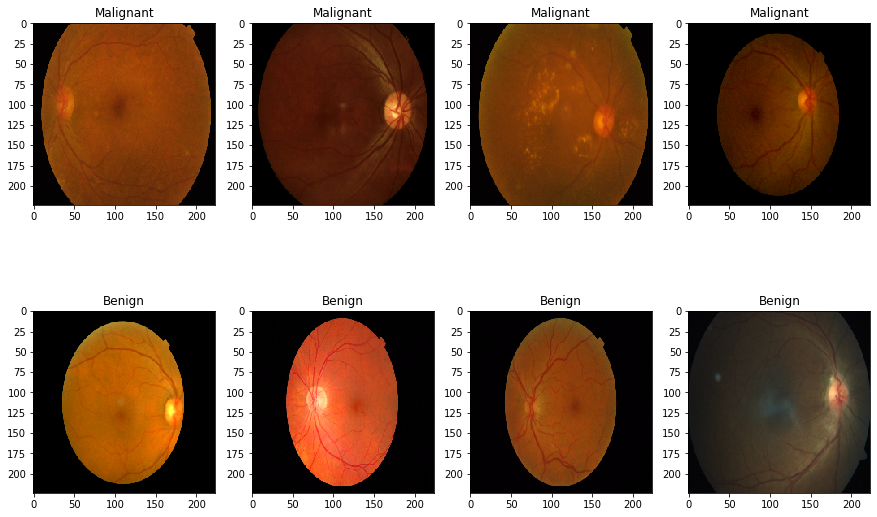

In [9]:

# # Display first 8 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, 9):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [10]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model: ResNet50

In [11]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(4, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [12]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

74850304/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4)                 7684      
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [14]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=1,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/30
1/1 [==============================] - ETA: 0s - loss: 0.9188 - accuracy: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to weights.best.hdf5
1/1 [==============================] - 40s 40s/step - loss: 0.9188 - accuracy: 0.0000e+00 - val_loss: 0.6901 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.4444
Epoch 2: val_accuracy did not improve from 0.33333
1/1 [==============================] - 0s 414ms/step - loss: 0.7051 - accuracy: 0.4444 - val_loss: 0.7586 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 0.7440 - accuracy: 0.2222
Epoch 3: val_accuracy did not improve from 0.33333
1/1 [==============================] - 0s 315ms/step - loss: 0.7440 - accuracy: 0.2222 - val_loss: 0.8278 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/30
1/1 [==============================] - ETA: 0s - loss: 0.7579 - accurac

In [15]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

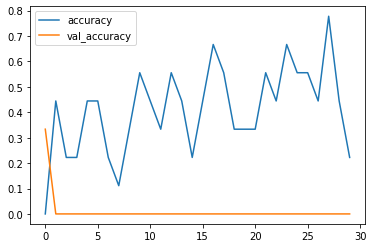

In [16]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

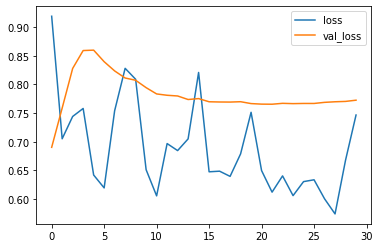

In [17]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [18]:
model.load_weights("weights.best.hdf5")

In [19]:
Y_val_pred = model.predict(x_val)

In [20]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.3333333333333333

In [21]:
Y_pred = model.predict(X_test)

In [23]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = 1)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


### Confusion Matrix

Confusion matrix, without normalization
[[1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]]


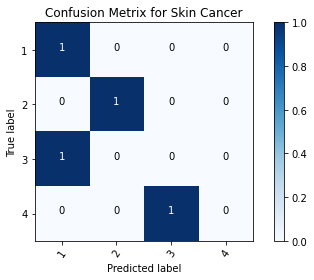

In [24]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['1', '2', '3' , '4']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]


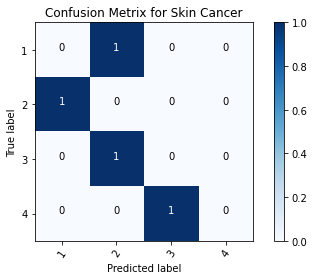

In [25]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['1', '2', '3' , '4']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

### Classification Report

In [26]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       1.0\n           1       0.00      0.00      0.00       1.0\n           2       0.00      0.00      0.00       1.0\n           3       0.00      0.00      0.00       1.0\n\n    accuracy                           0.00       4.0\n   macro avg       0.00      0.00      0.00       4.0\nweighted avg       0.00      0.00      0.00       4.0\n'